<a href="https://colab.research.google.com/github/Somtochukwu-Achikanu/Projects/blob/main/Disaster_tweet_claassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,ConfusionMatrixDisplay,roc_auc_score,roc_curve,auc
from wordcloud import WordCloud
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords,wordnet
from nltk.stem import SnowballStemmer,WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import gensim
from gensim.models import Word2Vec

test_df = pd.read_csv('/content/test.csv')
print(test_df.head())

train_df = pd.read_csv('/content/train.csv')
print(train_df.head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


Data exploration

0    4342
1    3271
Name: target, dtype: int64


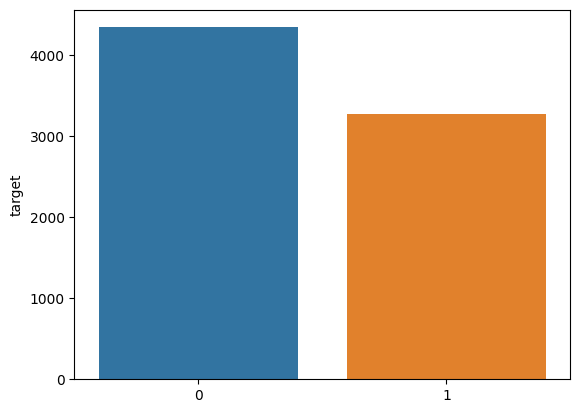

In [ ]:
#To check and plot the value count of the disaster tweets(1) and non_disaster tweets(0)
count = train_df['target'].value_counts()
print(count)
sns.barplot(x=count.index,y =count)
plt.show()


In [ ]:
#Check the missing values in the dataset

missing_values_count = train_df.isna().sum()
print(missing_values_count)

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [ ]:
#wordcount for each diasaster and nondisaster tweets

train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
disaster_count = train_df[train_df['target']==1]['word_count'].mean()
print(disaster_count)
non_disaster_count = train_df[train_df['target']==0]['word_count'].mean()
print(non_disaster_count)


15.167532864567411
14.704744357438969


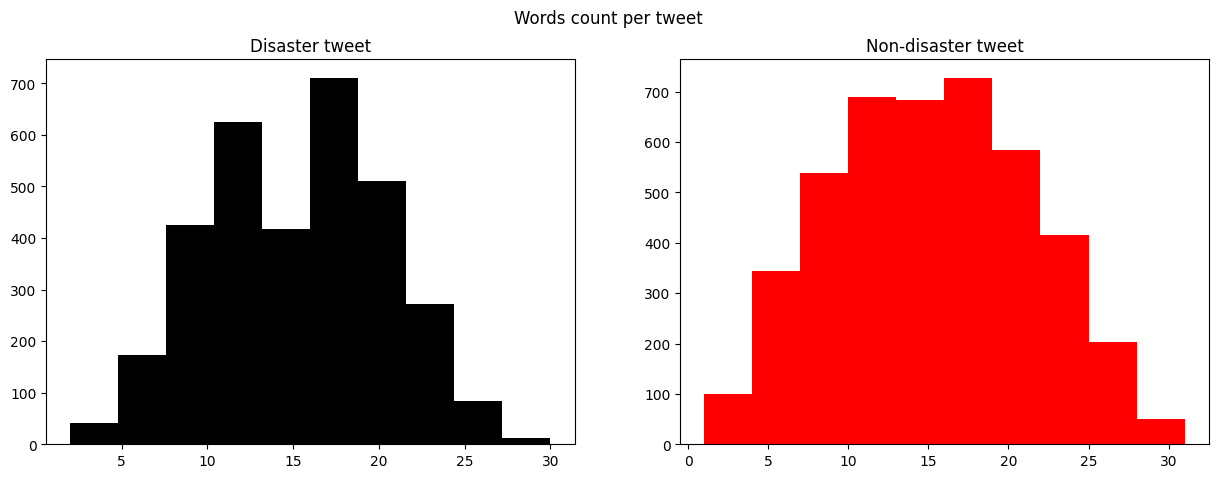

In [ ]:
#plotting the word count
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.hist(train_df[train_df['target']==1]['word_count'],color='k')
ax1.set_title('Disaster tweet')
ax2.hist(train_df[train_df['target']==0]['word_count'],color='r')
ax2.set_title('Non-disaster tweet')
fig.suptitle('Words count per tweet')
plt.show()

In [ ]:
#Number of character in a tweet
train_df['char_count'] = train_df['text'].apply(lambda x:len(str(x)))

disaster_char_count = train_df[train_df['target']==1]['char_count'].mean()
print(disaster_char_count)

non_disaster_char_count = train_df[train_df['target']==0]['char_count'].mean()
print(non_disaster_char_count)


108.11342097217977
95.70681713496084


In [ ]:
from sklearn import preprocessing
#Text Preprocessing, removing shortforms,stemming and lemmatization
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower()
    text=text.strip()
    text=re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text)
    text= re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text)
    text = re.sub(r'\s+',' ',text)
    return text

# Removal of words with length<2
    text = [i for i in text if len(i)>2]
    text = ' '.join(text)
    return text

# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()

# Function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string))
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(a)

def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

train_df['clean_text'] = train_df['text'].apply(lambda x: finalpreprocess(x))
train_df.head()



,id,keyword,location,text,target,word_count,char_count,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,133,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,get sent photo ruby alaska smoke wildfires pou...


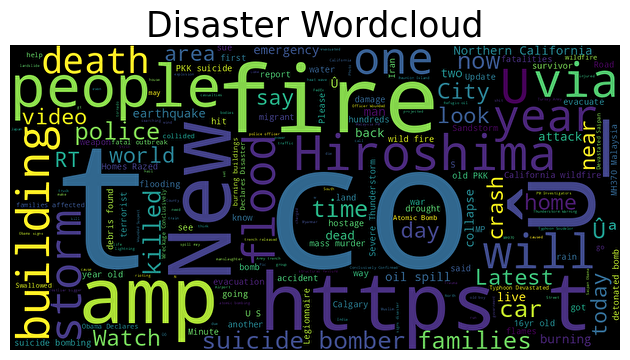

In [ ]:
#word cloud for disaster and non disaster tweets
disaster = ' '.join(train_df[train_df['target']==1]['text'])
non_disaster =''.join(train_df[train_df['target']==0]['text'])

wordcloud = WordCloud(width=1000,height=500).generate(disaster)
plt.imshow(wordcloud,interpolation='sinc',cmap='Accent')
plt.axis('off')
plt.tight_layout()
plt.title('Disaster Wordcloud',fontsize= 25,color='k')
plt.show()

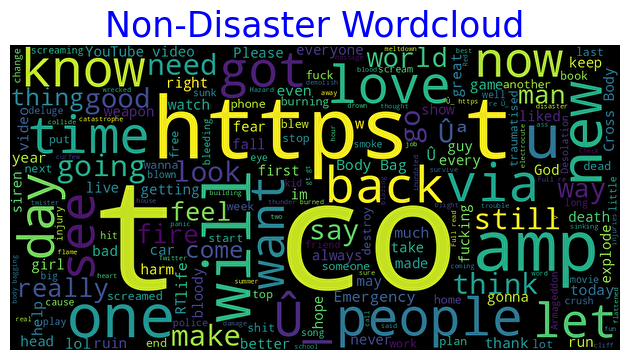

In [ ]:
wordcloud = WordCloud(width=1000,height=500).generate(non_disaster)
plt.imshow(wordcloud,interpolation='sinc',cmap='gist_heat_r')
plt.axis('off')
plt.tight_layout()
plt.title('Non-Disaster Wordcloud',fontsize= 25,color='b')
plt.show()

In [ ]:
#Word vectorization and data split
X_train,X_test,y_train,y_test = train_test_split(train_df['clean_text'],train_df['target'],test_size=0.3,random_state=1)

#building Word2Vec model
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)
print(X_train_vectors_tfidf.shape)
print(X_test_vectors_tfidf.shape)


(5329, 15802)
(2284, 15802)


              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1326
           1       0.80      0.70      0.75       958

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284

AUC: 0.8645430871883039


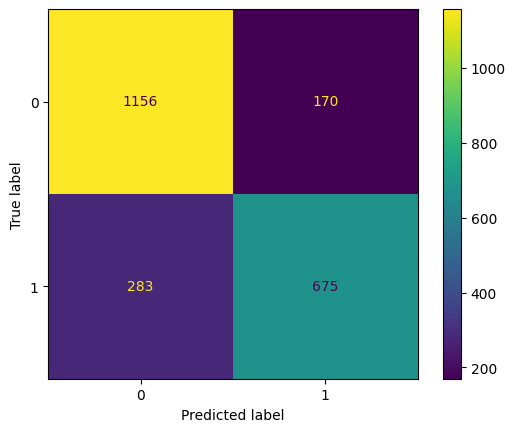

In [ ]:
#Machine learning models

log_reg = LogisticRegression(random_state=1)

#Fit the training data into the model
log_reg.fit(X_train_vectors_tfidf, y_train)
pipe_logreg = make_pipeline(log_reg)
pipe_logreg.fit(X_train_vectors_tfidf, y_train)
pred = pipe_logreg.predict(X_test_vectors_tfidf)
y_prob = pipe_logreg.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,pred))
ConfusionMatrixDisplay(confusion_matrix(y_test,pred)).plot()
logreg_score = accuracy_score(y_test,pred)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_lr = auc(fpr, tpr)
print('AUC:', roc_lr)

              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1326
           1       0.86      0.62      0.72       958

    accuracy                           0.80      2284
   macro avg       0.81      0.77      0.78      2284
weighted avg       0.81      0.80      0.79      2284

AUC: 0.8645430871883039


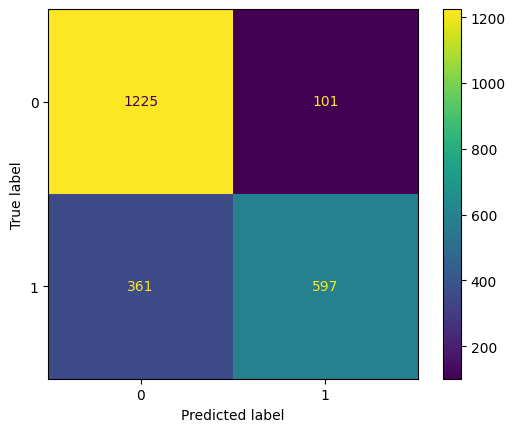

In [ ]:
rf = RandomForestClassifier(random_state =1)
pipe_rf = make_pipeline(rf)
pipe_rf.fit(X_train_vectors_tfidf, y_train)
pred = pipe_rf.predict(X_test_vectors_tfidf)
y_prob = pipe_logreg.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,pred))
ConfusionMatrixDisplay(confusion_matrix(y_test,pred)).plot()
rf_accuracy = accuracy_score(y_test,pred)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_rf = auc(fpr, tpr)
print('AUC:', roc_rf)

              precision    recall  f1-score   support

           0       0.79      0.91      0.85      1326
           1       0.84      0.68      0.75       958

    accuracy                           0.81      2284
   macro avg       0.82      0.79      0.80      2284
weighted avg       0.81      0.81      0.81      2284

AUC: 0.8645430871883039


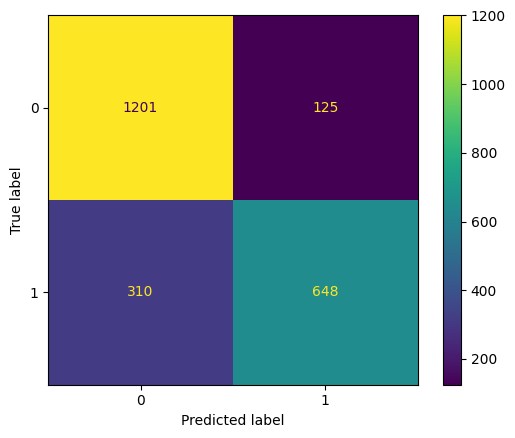

In [ ]:
svc = SVC(random_state=1)
pipe_svc = make_pipeline(svc)
pipe_svc.fit(X_train_vectors_tfidf, y_train)
pred = pipe_svc.predict(X_test_vectors_tfidf)
y_prob = pipe_logreg.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test, pred))
ConfusionMatrixDisplay(confusion_matrix(y_test,pred)).plot()
svc_accuracy = accuracy_score(y_test,pred)
rf_accuracy = accuracy_score(y_test,pred)
fpr, tpr, thresholds = roc_curve(y_test,y_prob)
roc_svc = auc(fpr, tpr)
print('AUC:', roc_svc)

              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1326
           1       0.84      0.65      0.73       958

    accuracy                           0.80      2284
   macro avg       0.81      0.78      0.79      2284
weighted avg       0.81      0.80      0.80      2284

AUC: 0.862670313026447


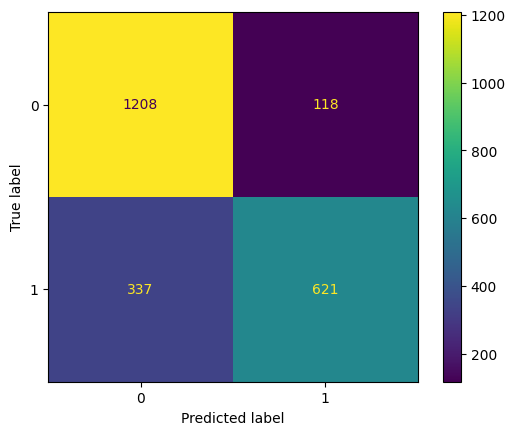

In [ ]:
naive_bayes = MultinomialNB()
pipe_nb = make_pipeline(naive_bayes)
pipe_nb.fit(X_train_vectors_tfidf, y_train)
pred = pipe_nb.predict(X_test_vectors_tfidf)
print(classification_report(y_test, pred))
ConfusionMatrixDisplay(confusion_matrix(y_test,pred)).plot()
nb_accuracy = accuracy_score(y_test, pred)
y_prob = pipe_nb.predict_proba(X_test_vectors_tfidf)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_nb = auc(fpr, tpr)
print('AUC:', roc_nb)


              precision    recall  f1-score   support

           0       0.75      0.90      0.82      1326
           1       0.82      0.59      0.69       958

    accuracy                           0.77      2284
   macro avg       0.79      0.75      0.75      2284
weighted avg       0.78      0.77      0.77      2284

AUC: 0.8325894192589514


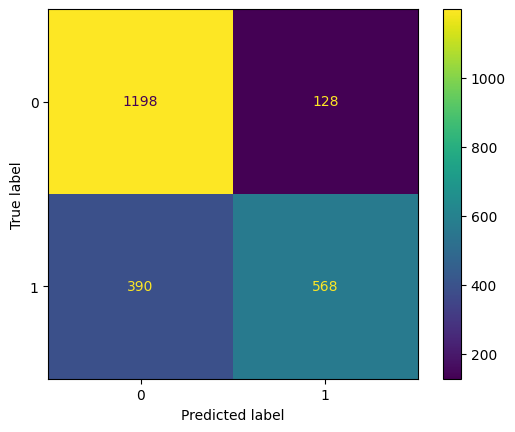

In [ ]:
xgb = XGBClassifier(random_state = 1)

pipe_xgb = make_pipeline(xgb)
pipe_xgb.fit(X_train_vectors_tfidf, y_train)
pred = pipe_xgb.predict(X_test_vectors_tfidf)
print(classification_report(y_test,pred))
ConfusionMatrixDisplay(confusion_matrix(y_test,pred)).plot()
xgb_accuracy = accuracy_score(y_test,pred)
y_prob = pipe_xgb.predict_proba(X_test_vectors_tfidf)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_xgb = auc(fpr, tpr)
print('AUC:', roc_xgb)

In [ ]:
data = {'models': ['Logistic Regression','Random Forest Classifier','SVC','Naive Bayes','XGB Classifier'],
        'Score':  [logreg_score, rf_accuracy,svc_accuracy,nb_accuracy,xgb_accuracy,],
        'AUC':    [roc_lr,roc_rf,roc_svc,roc_nb,roc_xgb]}
df = pd.DataFrame(data)
df[['Score','AUC']] =df[['Score','AUC']]*100
df.sort_values(by=['Score','AUC'],ascending=False)

,models,Score,AUC
1,Random Forest Classifier,80.954466,86.454309
2,SVC,80.954466,86.454309
0,Logistic Regression,80.166375,86.454309
3,Naive Bayes,80.078809,86.267031
4,XGB Classifier,77.320490,83.258942


In [ ]:
#Pre-processing the new dataset
test_df['clean_text'] = test_df['text'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test = test_df['clean_text']

#converting words to numerical data using tf-idf
X_vector= tfidf_vectorizer.transform(X_test)

#use the best model(Random Forest Classifier) to predict 'target' value for the new dataset
y_predict = rf.predict(X_vector)
y_prob = rf.predict_proba(X_vector)[:,1]
test_df['predict_prob']= y_prob
test_df['target']= y_predict
final=test_df[['id','target']].reset_index(drop=True)
print(final.head())

   id  target
0   0       0
1   2       1
2   3       1
3   9       0
4  11       1


In [ ]:
final.to_csv('submission.csv',index=False)
print(final)

         id  target
0         0       0
1         2       1
2         3       1
3         9       0
4        11       1
...     ...     ...
3258  10861       0
3259  10865       1
3260  10868       1
3261  10874       1
3262  10875       0

[3263 rows x 2 columns]
